# Import Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc, plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 


import shap

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Datasets

In [106]:
df = pd.read_csv('C:\\Users\\Muhammad Hazim\\Desktop\\bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [107]:
df.isnull().any().any()

False

In [108]:
cat_feat = []
num_feat = []

for column in df.drop('deposit', axis = 1).columns.values:
    if df[column].nunique() < 20:
        cat_feat.append(column)   
    else: 
        num_feat.append(column)

# Distribution of Target

<AxesSubplot:xlabel='deposit', ylabel='count'>

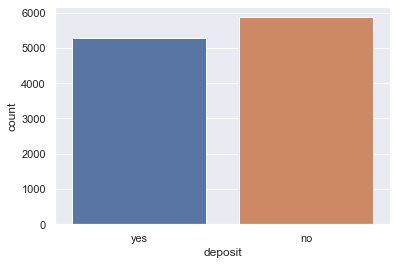

In [109]:
sns.countplot(df['deposit'])

In [110]:
def distribution_num_feat(column):
    fig, ax = plt.subplots(1, 3, figsize = (20,5))

    sns.distplot(df[column], ax = ax[0])
    sns.boxplot(df[column], ax = ax[1])
    sns.boxplot(df['deposit'], df[column], ax = ax[2])

# Distribution of Numerical Features against Target

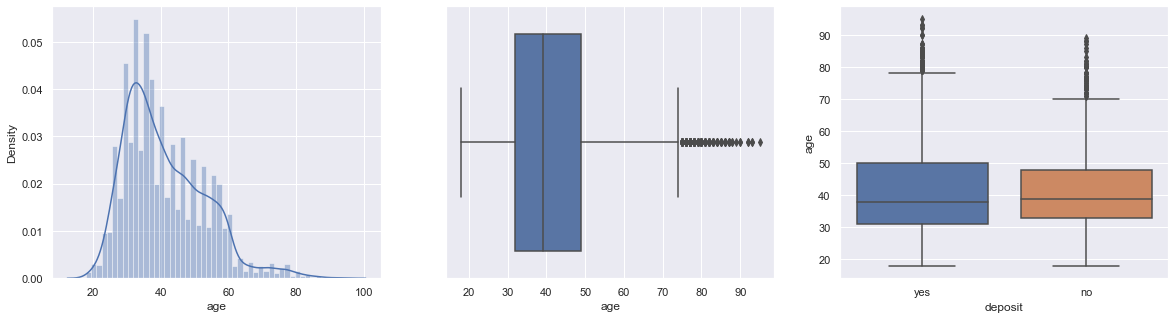

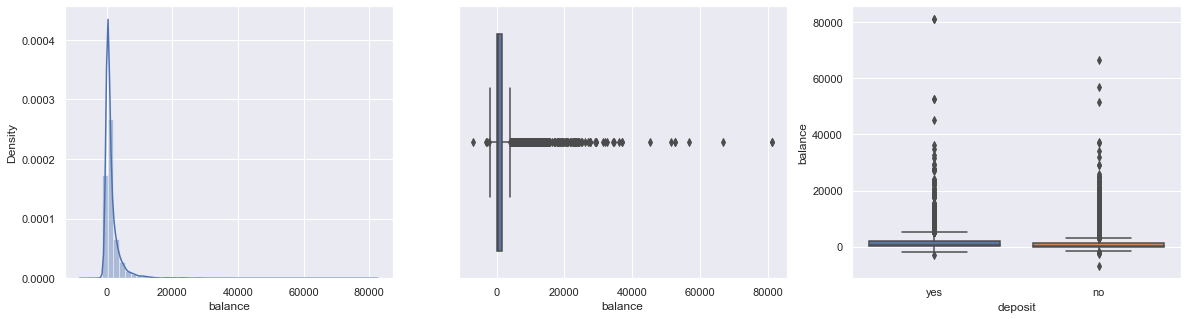

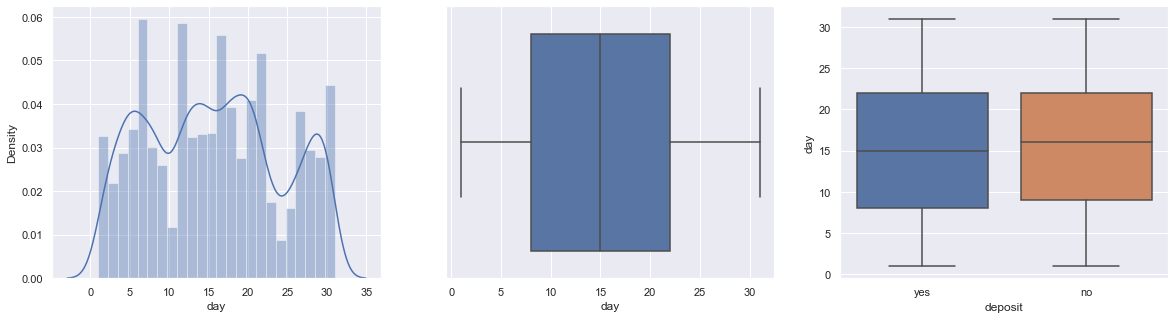

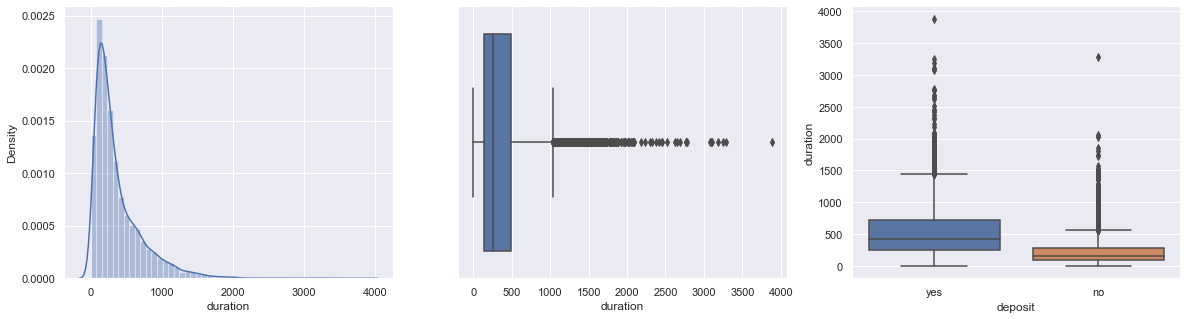

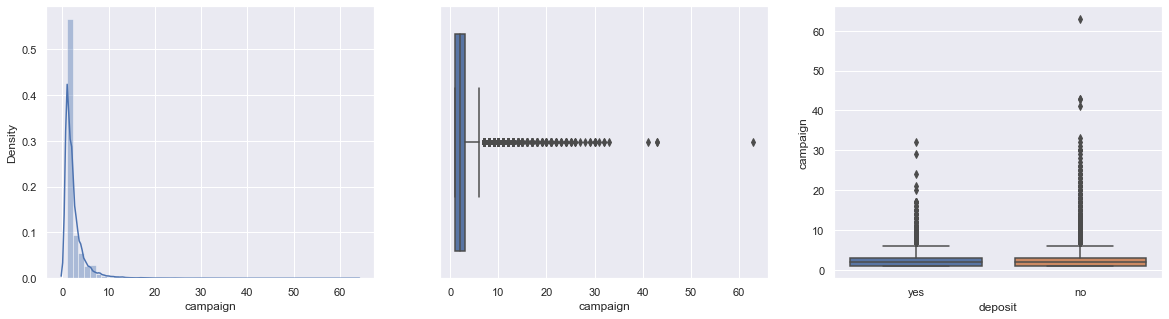

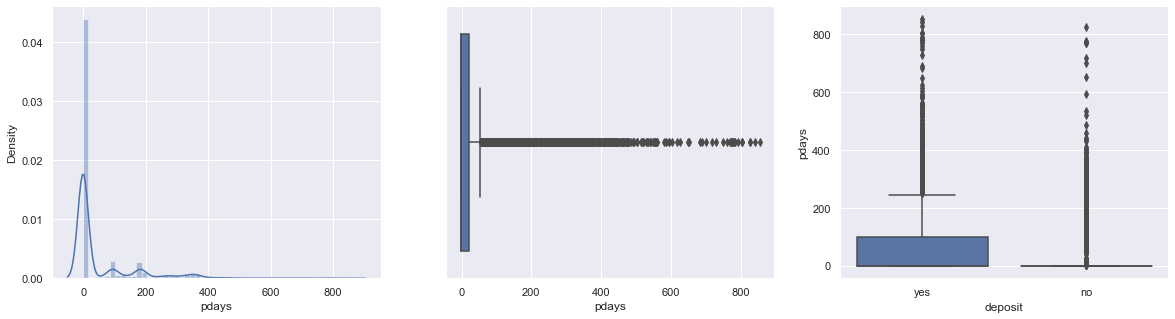

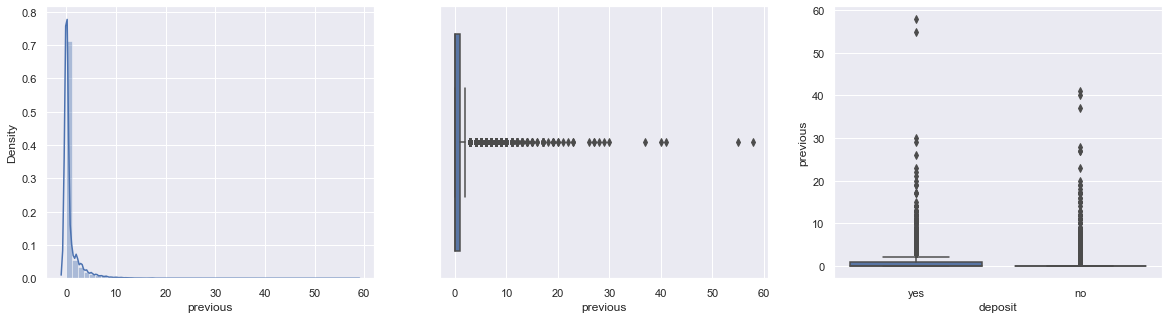

In [111]:
for column in num_feat:
    distribution_num_feat(column)

In [112]:
df.deposit = df.deposit.map({'yes':1, 'no':0})

In [113]:
def distribution_cat_feat(column):
    fix, ax = plt.subplots(1, 2, figsize = (15,5))

    sns.countplot(df[column], ax = ax[0])
    df[[column, 'deposit']].groupby(column).mean().sort_values(by = 'deposit', ascending = False).plot(kind = 'bar', ax = ax[1])

# Distribution of Categorical Features against Target

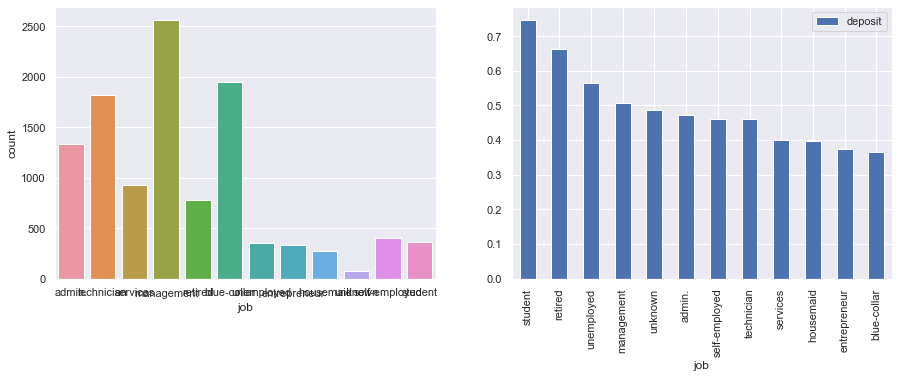

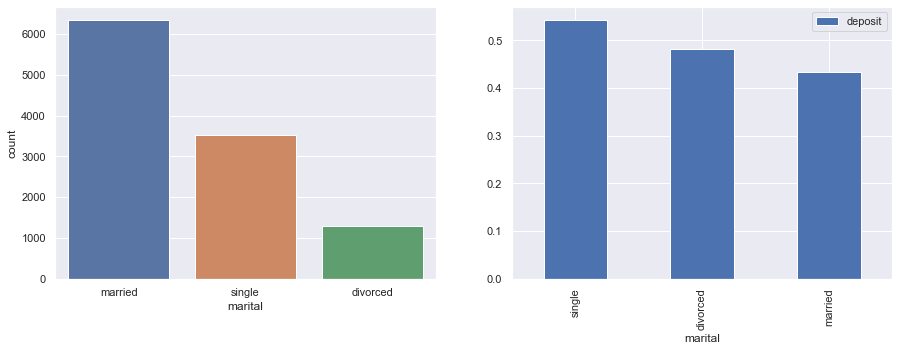

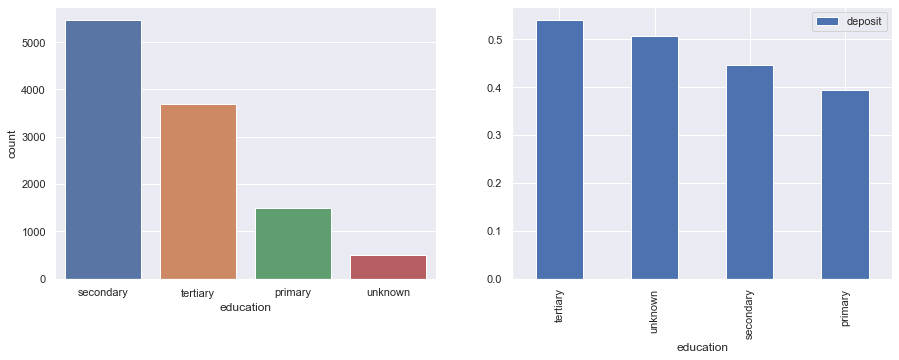

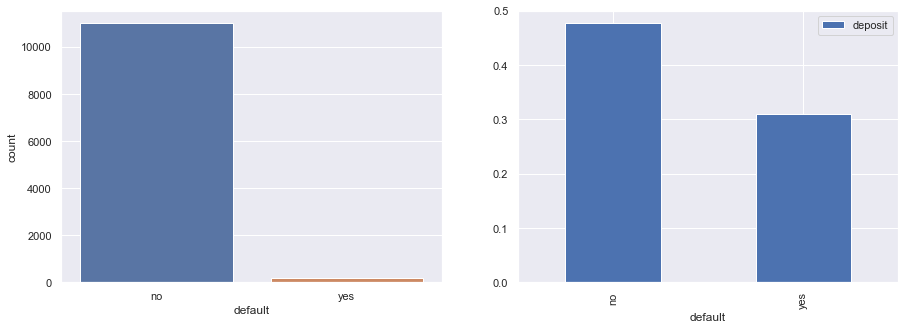

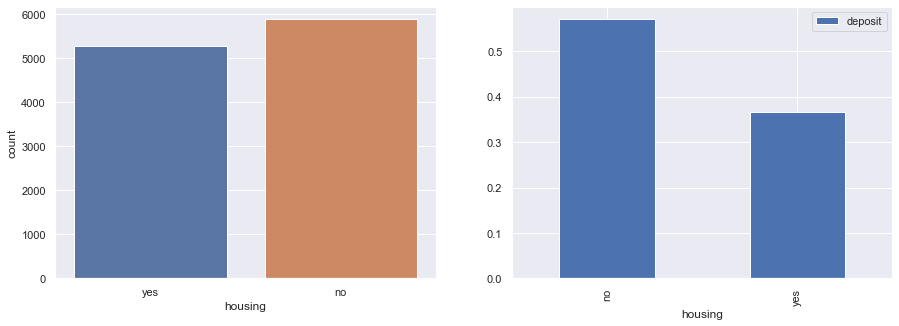

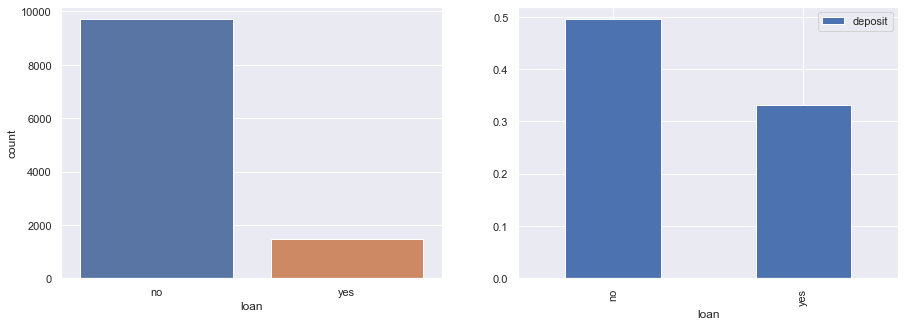

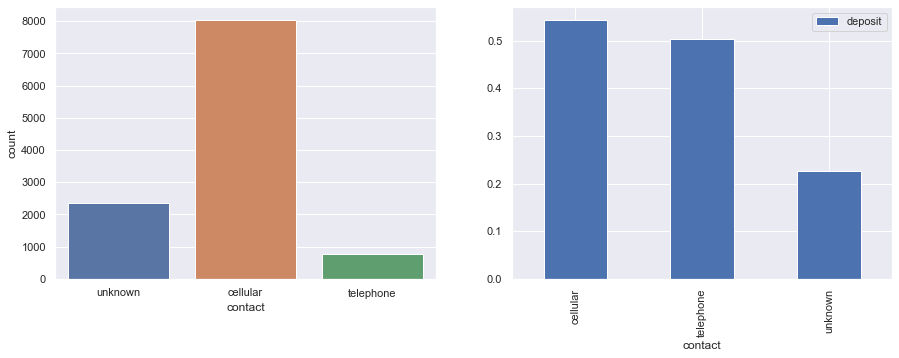

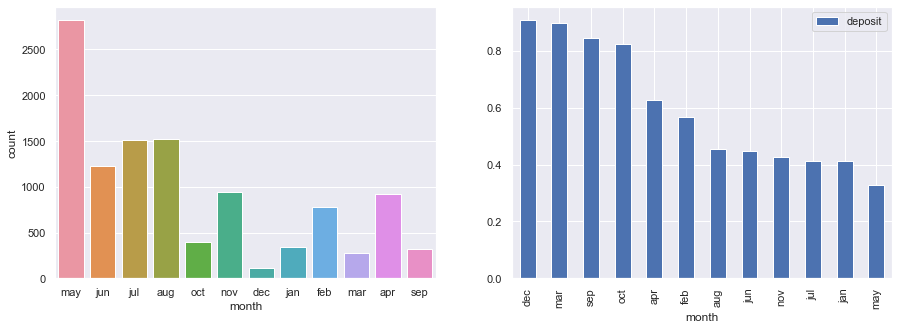

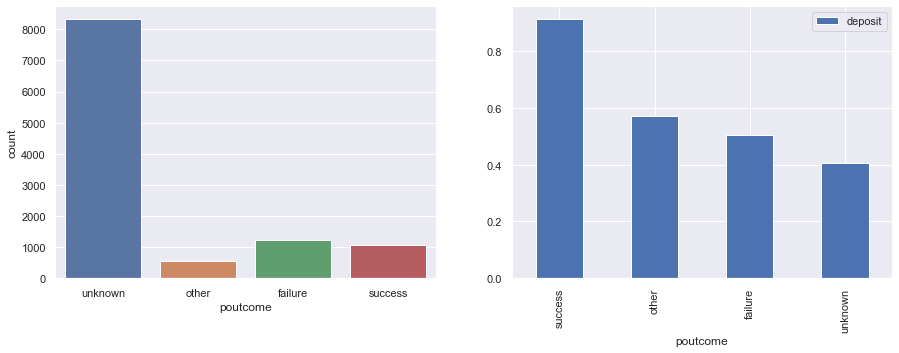

In [114]:
for column in cat_feat:
    distribution_cat_feat(column)

# Correlation Matrix

<AxesSubplot:>

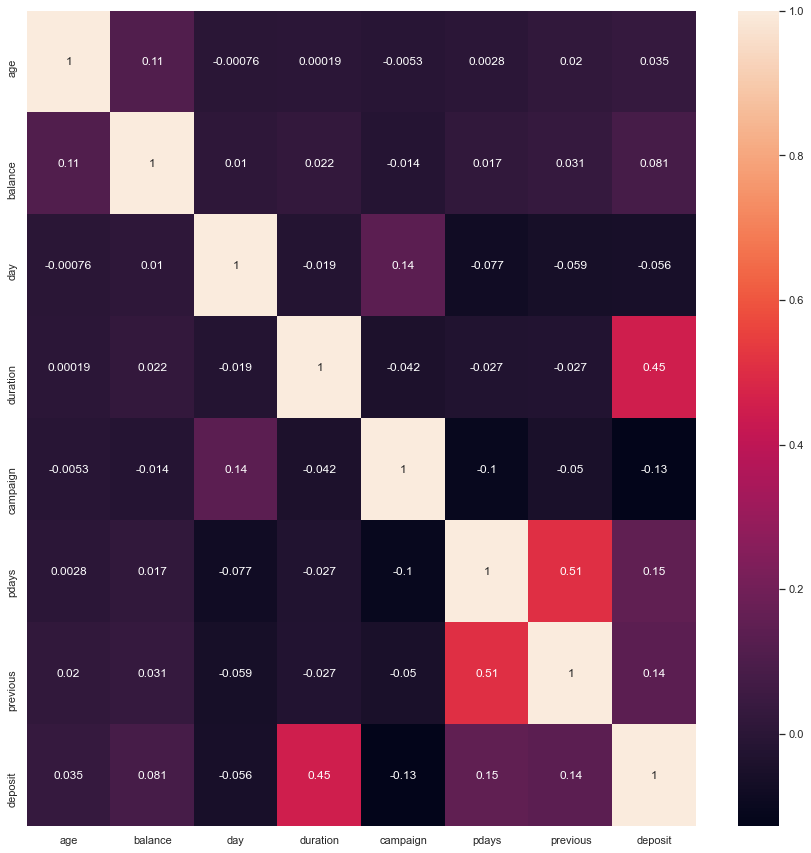

In [115]:
plt.figure(figsize = (15, 15))
sns.heatmap(df.corr(), annot = True)

In [116]:
df.loc[ df['age'] <= 25, 'age'] = 1
df.loc[(df['age'] > 25) & (df['age'] <= 35), 'age'] = 2
df.loc[(df['age'] > 35) & (df['age'] <= 45), 'age'] = 3
df.loc[(df['age'] > 45) & (df['age'] <= 60), 'age'] = 4
df.loc[ df['age'] > 60, 'age'] = 5

<AxesSubplot:xlabel='age'>

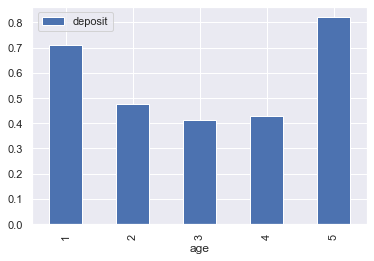

In [117]:
df[['age', 'deposit']].groupby('age').mean().sort_values(by = 'age').plot(kind = 'bar')

In [118]:
df.contact = df.contact.map({'unknown':0, 'cellular':1, 'telephone':1})

In [119]:
df.month = df.month.map({'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 'nov':11, 'dec':12, 'jan':1, 'feb':2,
       'mar':3, 'apr':4, 'sep':9})

In [120]:
df.poutcome = df.poutcome.replace('other','unknown')

In [121]:
df.duration = df.duration/60

In [122]:
df.pdays = df.pdays.replace(-1,0)

In [123]:
df.default = df.default.map({'no':0, 'yes':1})

In [124]:
df.housing = df.housing.map({'no':0, 'yes':1})

In [125]:
df.loan = df.loan.map({'no':0, 'yes':1})

In [126]:
x = df.drop("deposit", axis=1)
y = df["deposit"]

In [127]:
categorical_features = np.where(x.dtypes != np.float)[0]
categorical_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15],
      dtype=int64)

In [128]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

In [129]:
def score(model):
    df1 = pd.DataFrame(index = ['Accuracy', 'Precision', 'Recall', 'ROC AUC'] )
    df1['Train Score'] = [accuracy_score(y_train, model.predict(x_train)), precision_score(y_train, model.predict(x_train)), recall_score(y_train, model.predict(x_train)), roc_auc_score(y_train, model.predict_proba(x_train)[:,1])]
    df1['Test Score'] = [accuracy_score(y_test, model.predict(x_test)), precision_score(y_test, model.predict(x_test)), recall_score(y_test, model.predict(x_test)), roc_auc_score(y_test, model.predict_proba(x_test)[:,1])]        
    return df1

# Catboost Classifier

In [130]:
cb=CatBoostClassifier(learning_rate=0.001, eval_metric='AUC')
cb.fit(x_train, y_train, cat_features = categorical_features, eval_set=(x_test, y_test),verbose = False ,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [131]:
score(cb)

,Train Score,Test Score
Accuracy,0.858775,0.850425
Precision,0.829707,0.818662
Recall,0.883243,0.879017
ROC AUC,0.927304,0.924636


In [132]:
shap_values = shap.TreeExplainer(cb).shap_values(x_test) 

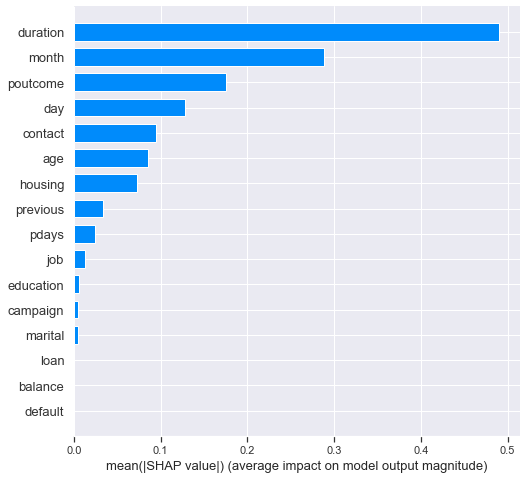

In [133]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')

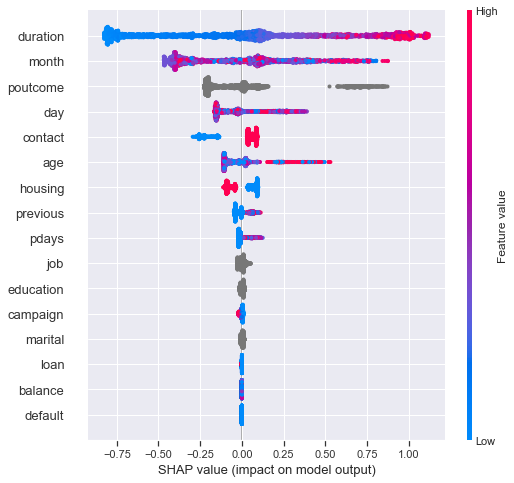

In [134]:
shap.summary_plot(shap_values, x_test)

In [135]:
y_prob_train = cb.predict_proba(x_train)[:,1]
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(y_train, y_prob_train)
roc_auc_train = auc(false_positive_rate_train, true_positive_rate_train)

y_prob_test = cb.predict_proba(x_test)[:,1]
false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(false_positive_rate_test, true_positive_rate_test)

Text(0.5, 0, 'False Positive Rate')

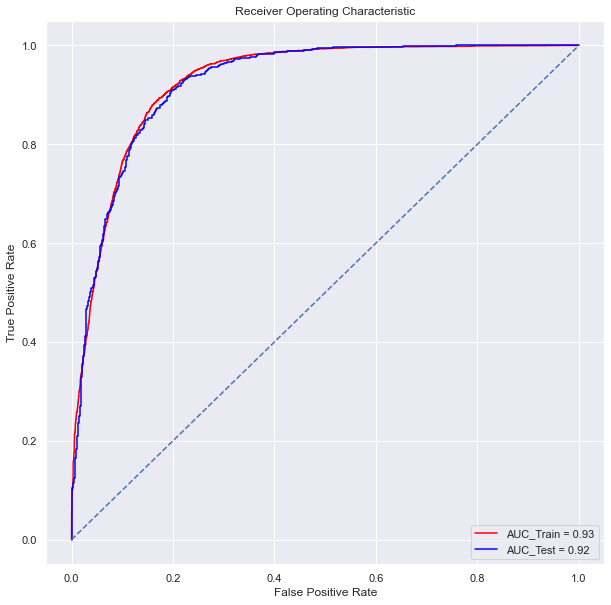

In [136]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_train,true_positive_rate_train, color='red',label = 'AUC_Train = %0.2f' % roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot(false_positive_rate_test,true_positive_rate_test, color='blue',label = 'AUC_Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Other Models

In [137]:
df.month = df.month.astype('str')

In [138]:
df = pd.get_dummies(df, drop_first = True)

In [139]:
x = df.drop("deposit", axis=1)
y = df["deposit"]

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

# Logistic Regression

In [141]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
score(lr)

,Train Score,Test Score
Accuracy,0.799530,0.798477
Precision,0.800246,0.795720
Recall,0.768849,0.773157
ROC AUC,0.879518,0.882374


# Decision Tree Classifier`

In [142]:
dt = DecisionTreeClassifier(max_depth = 8)
dt.fit(x_train, y_train)
score(dt)

,Train Score,Test Score
Accuracy,0.849703,0.821764
Precision,0.825118,0.796763
Recall,0.866462,0.837429
ROC AUC,0.921603,0.882577


In [147]:
shap_values = shap.TreeExplainer(dt).shap_values(x_test) 

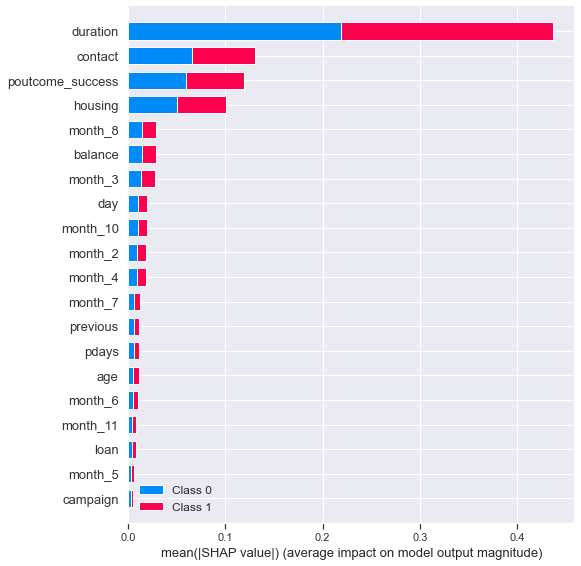

In [148]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')

# Random Forest Classifier

In [143]:
rf = RandomForestClassifier(max_depth = 12)
rf.fit(x_train, y_train)
score(rf)

,Train Score,Test Score
Accuracy,0.911188,0.854456
Precision,0.888738,0.822339
Recall,0.928858,0.883743
ROC AUC,0.978935,0.918419


In [151]:
shap_values = shap.TreeExplainer(rf).shap_values(x_test) 

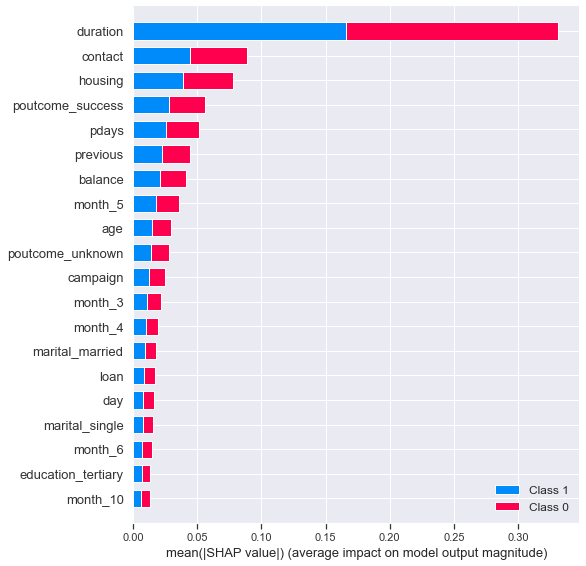

In [152]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')

# XGB Classifier

In [144]:
xgb = XGBClassifier(max_depth = 4)
xgb.fit(x_train, y_train)
score(xgb)

,Train Score,Test Score
Accuracy,0.901669,0.864756
Precision,0.877505,0.838710
Recall,0.921059,0.884688
ROC AUC,0.968149,0.927918


In [154]:
shap_values = shap.TreeExplainer(xgb).shap_values(x_test) 

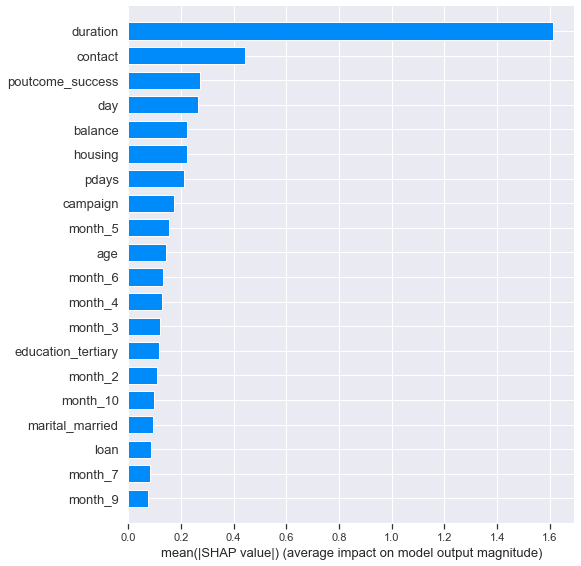

In [155]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')

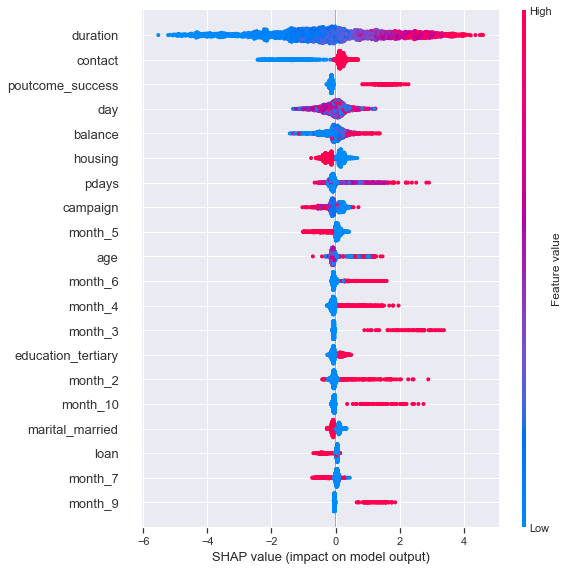

In [156]:
shap.summary_plot(shap_values, x_test)

# Light GBM Classifier

In [145]:
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)
score(lgbm)

,Train Score,Test Score
Accuracy,0.908612,0.869234
Precision,0.878184,0.838339
Recall,0.937131,0.896975
ROC AUC,0.972990,0.929794


In [160]:
shap_values = shap.TreeExplainer(lgbm).shap_values(x_test) 

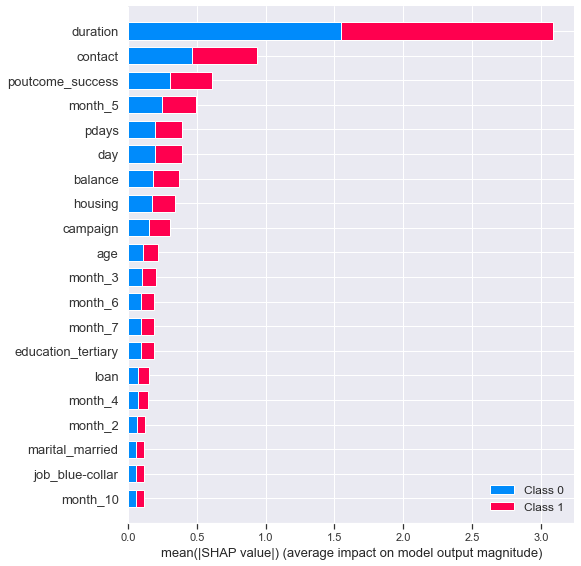

In [167]:
shap.summary_plot(shap_values, x_test, plot_type = 'bar')